In [ ]:

def get_glasser():
    '''
    Navigates through file tree and extracts FCs with optional reconstruction
    '''
    # Yeo ordering
    fname = '../data/100_unrelated.csv'
    yeo = True
    if yeo:
        yeo_order = list(sio.loadmat("../data/yeo_RS7_N374.mat",
                                     squeeze_me=True,
                                     struct_as_record=False)['yeoOrder'] - 1)
    # Load subject ID and task names
    subjectids = np.loadtxt(fname, dtype=np.int)
    nSubj = len(subjectids)
    tasks = ['rfMRI_REST1_LR', 'rfMRI_REST1_RL', 'rfMRI_REST2_LR',
             'rfMRI_REST2_RL', 'tfMRI_EMOTION_LR', 'tfMRI_EMOTION_RL',
             'tfMRI_GAMBLING_LR', 'tfMRI_GAMBLING_RL', 'tfMRI_LANGUAGE_LR',
             'tfMRI_LANGUAGE_RL', 'tfMRI_MOTOR_LR', 'tfMRI_MOTOR_RL',
             'tfMRI_RELATIONAL_LR', 'tfMRI_RELATIONAL_RL', 'tfMRI_SOCIAL_LR',
             'tfMRI_SOCIAL_RL', 'tfMRI_WM_LR', 'tfMRI_WM_RL']
    M = {}
    # Walk through file tree and extract FCs
    for task in tasks:
        masterFC_dir = '../data/results_SIFT2'
        restingstatename = 'fMRI/' + task + '/FC/FC_glasser_subc_GS_bp_z.mat'
        task_matrices = []
        for subject in subjectids:
            filename = masterFC_dir + '/' + \
                str(subject) + '/' + restingstatename
            mat = sio.loadmat(filename, squeeze_me=True,
                              struct_as_record=False)
            A_orig = mat['FC']
            if yeo:
                A_orig = A_orig[np.ix_(yeo_order, yeo_order)]
            np.fill_diagonal(A_orig, 1)
            task_matrices.append(A_orig)
        M[task] = np.array(task_matrices)
    test = np.concatenate((M['rfMRI_REST1_LR'], M['tfMRI_EMOTION_LR'],
                           M['tfMRI_GAMBLING_LR'], M['tfMRI_LANGUAGE_LR'],
                           M['tfMRI_MOTOR_LR'], M['tfMRI_RELATIONAL_LR'],
                           M['tfMRI_SOCIAL_LR'], M['tfMRI_WM_LR']))
    retest = np.concatenate((M['rfMRI_REST1_RL'], M['tfMRI_EMOTION_RL'],
                             M['tfMRI_GAMBLING_RL'], M['tfMRI_LANGUAGE_RL'],
                             M['tfMRI_MOTOR_RL'], M['tfMRI_RELATIONAL_RL'],
                             M['tfMRI_SOCIAL_RL'], M['tfMRI_WM_RL']))
    del M
    all_FC = np.concatenate((test, retest))
    del test, retest
    return all_FC, nSubj


def get_schaefer(parc, ref='original'):
    if ref.lower() == 'original' or ref.lower() == 'geodesic':
        with open(f'../data/schaefer/schaefer{parc}.pickle', 'rb') as f:
            all_FC = pickle.load(f)
    else:
        with open(f'../data/tangent_fcs/schaefer/schaefer{parc}_{ref}.pickle', 'rb') as f:
            all_FC = pickle.load(f)
    nSubj = int(all_FC.shape[0]/16)
    return all_FC, nSubj


def q1invm(q1, eig_thresh=0):
    q1 += np.eye(q1.shape[0])
    U, S, V = scipy.linalg.svd(q1)
    S = np.diag(S ** (-1 / 2))
    Q1_inv_sqrt = U @ S @ V
    Q1_inv_sqrt = (Q1_inv_sqrt + np.transpose(Q1_inv_sqrt)) / 2
    return Q1_inv_sqrt


def qlog(q):
    U, S, V = scipy.linalg.svd(q)
    s = np.diag(S)
    S = np.diag(np.log(s))
    Q = U @ S @ V
    return Q


def tangential(all_FC, ref):
    # Regularization for riemann
    if ref in ['riemann', 'kullback_sym', 'logeuclid']:
        print("Adding regularization!")
        eye_mat = np.eye(all_FC.shape[1])
        scaling_mat = np.repeat(eye_mat[None, ...], all_FC.shape[0], axis=0)
        all_FC += scaling_mat
    Cg = mean_covariance(all_FC, metric=ref)
    Q1_inv_sqrt = q1invm(Cg)
    Q = Q1_inv_sqrt @ all_FC @ Q1_inv_sqrt
    tangent_FC = np.empty(Q.shape)
    for idx, fc in enumerate(Q):
        if idx % 100 == 0:
            print(f'{idx}/{Q.shape[0]}')
        tangent_FC[idx] = linalg.logm(fc)
    return tangent_FC

def utri2mat(utri):
    n = int(-1 + np.sqrt(1 + 8 * len(utri))) // 2
    iu1 = np.tril_indices(n+1,-1)
    ret = np.empty((n+1, n+1))
    ret[iu1] = utri
    ret.T[iu1] = utri
    np.fill_diagonal(ret, 1)
    return ret
   

### Visualize tangent reference matrices

In [ ]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import seaborn as sns
from pyriemann.utils.mean import mean_covariance

for ref in ['riemann']: # choose reference(s) here
    all_FC, nSubj = get_schaefer(100)
    print("All FCs successfully loaded!\n")
    if ref in ['riemann', 'kullback_sym', 'logeuclid']:
        print("Adding regularization!")
        eye_mat = np.eye(all_FC.shape[1])
        scaling_mat = np.repeat(eye_mat[None, ...], all_FC.shape[0], axis=0)
        all_FC += scaling_mat
    Cg = mean_covariance(all_FC, metric=ref)
    plt.style.use('default')
    sampleFC = Cg
    plt.imshow(sampleFC,origin='lower')
    plt.ylabel('Brain Regions')
    plt.xlabel('Brain Regions')
    plt.colorbar()
    plt.clim(np.percentile(Cg, 5), np.percentile(Cg, 95))
    plt.xticks([], [])
    plt.yticks([],[])
    plt.title(f'{ref}', fontdict = {'fontsize' : 20})
    plt.ylabel('Brain Regions',fontdict = {'fontsize' : 18})
    plt.xlabel('Brain Regions',fontdict = {'fontsize' : 18})
    plt.savefig(f'../results/tangent_references/reference_{ref}.eps', bbox_inches='tight')
    plt.show()

### Visualize tangent projected FCs

All FCs successfully loaded!



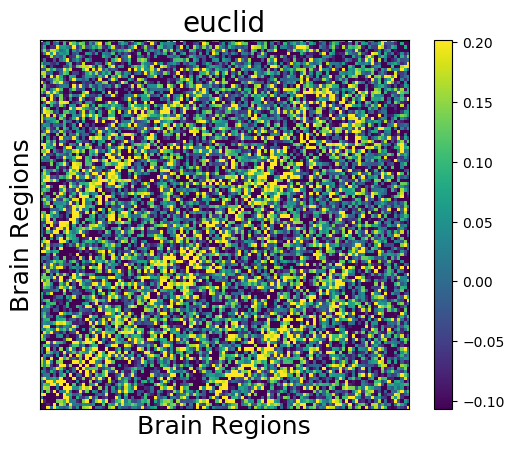

In [9]:
for ref in ['euclid']: # choose reference(s) here
    all_FC, nSubj = get_schaefer(100, ref)
    print("All FCs successfully loaded!\n")
    plt.style.use('default')
    sampleFC = all_FC[0]
    plt.imshow(sampleFC,origin='lower')
    plt.ylabel('Brain Regions')
    plt.xlabel('Brain Regions')
    plt.colorbar()
    plt.clim(np.percentile(Cg, 5), np.percentile(Cg, 95))
    plt.xticks([], [])
    plt.yticks([],[])
    plt.title(f'{ref}', fontdict = {'fontsize' : 20})
    plt.ylabel('Brain Regions',fontdict = {'fontsize' : 18})
    plt.xlabel('Brain Regions',fontdict = {'fontsize' : 18})
    plt.savefig(f'../results/tangent_fcs/projected_{ref}.eps', bbox_inches='tight')
    plt.show()